In [3]:
import numpy as np
import nilearn #tmp to have mni template
import SimpleITK as sitk
import math
from nilearn import image, plotting

/home/ltetrel/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Then, it will be a grid near the MNI152 template
spacing = (1., 1., 1.)
direction = (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
size = (250, 250, 250)
pixel_type = 8
origin = np.array([-89,  125, -71])
t = np.array([182., 218., 182.])

# we want the grid to have the same center as target
t = (t - np.array(spacing)*np.array(size))/2
# pixel (0,0,0) is at top left
origin = origin + t*np.array([1., -1., 1.])

# construction of the reference
ref_grid = sitk.Image(size, pixel_type)
ref_grid.SetOrigin(origin)
ref_grid.SetSpacing(spacing)
ref_grid.SetDirection(direction)

In [4]:
data_dir = "/home/ltetrel/Documents/data/preventad_prep/derivatives/deepneuroan/preprocess/"
filepath = data_dir + "sub-125043_ses-BL00_T1w_to_ref_grid.nii.gz"
t_name = "125043_NAPBL00_t1_to_MNI152.txt"
t_np = np.loadtxt(data_dir + "transfs/" + t_name)

# trying with a simple transform
# simple itk transform is indeed working
alpha = np.pi/16
t_np = np.array([[np.cos(alpha), -np.sin(alpha), 0, 0]
                 ,[np.sin(alpha), np.cos(alpha), 0, 0]
                 ,[0, 0, 1, 0]
                ,[0, 0, 0, 1]])

# template avg* is the same as mni*.mnc

# registration with minctracc without mask
#  1.11318945884705 0.0506609082221985 0.0192900244146585 -2.022629737854
#  -0.0583512559533119 1.15786218643188 0.326471537351608 -13.9837741851807
#  -0.0059832651168108 -0.376338630914688 1.333651304245 8.90363311767578;

# registration with minctracc with mask 125043/iteration1/template/mask_native.nii.gz just for BL00 !!!
# t_np = np.array([[1.06345736980438, 0.0391766466200352, 0.0446942299604416, -1.955242395401]
#                  ,[-0.0606516972184181, 1.1099591255188, 0.470217764377594, -11.7487096786499]
#                  ,[-0.0281794872134924, -0.454279899597168, 1.06870269775391, 9.42623424530029]
#                 ,[0, 0, 0, 1]])

# registration from niak
t_np = np.array([[1.06345736980438, 0.0391766466200352, 0.0446942299604416, -1.955242395401]
                 ,[-0.0606516972184181, 1.1099591255188, 0.470217764377594, -11.7487096786499]
                 ,[-0.0281794872134924, -0.454279899597168, 1.06870269775391, 9.42623424530029]
                ,[0, 0, 0, 1]])

affine = sitk.AffineTransform(3)
# rby default, order is not correct !
affine.SetParameters(t_np[:3,:4].ravel(order='F'))

source_brain = sitk.ReadImage(filepath, sitk.sitkFloat32)
brain_to_grid = sitk.Resample(source_brain, ref_grid, affine, sitk.sitkLinear, 0.0, sitk.sitkFloat32)

# sitk.WriteImage(source_brain, "/home/ltetrel/Documents/data/%s_source.nii.gz" %t_name[:6])
sitk.WriteImage(brain_to_grid, "/home/ltetrel/Documents/data/%s_to_grid.nii.gz" %t_name[:6])

RuntimeError: Exception thrown in SimpleITK ReadImage: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "/home/ltetrel/Documents/data/preventad_prep/derivatives/deepneuroan/preprocess/sub-125043_ses-BL00_T1w_to_ref_grid.nii.gz" does not exist.

In [8]:
data = "/home/ltetrel/Documents/data/neuromod/sub-05/ses-vid001/func/sub-05_ses-vid001_task-life_run-05_bold.nii.gz"
data = image.load_img(data)
plotting.view_img(image.mean_img(data))
# data.header.get_slice_times()

ValueError: File not found: '/home/ltetrel/Documents/data/neuromod/sub-05/ses-vid001/func/ses-vid001_task-video_run-01_bold_vol-001.nii.gz'

In [3]:
data = "/home/ltetrel/Documents/work/DeepNeuroAN/template/MNI152_T1_1mm_brain.nii.gz"
data = image.load_img(data)
data.affine

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [83]:
data = "/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/ses-vid001_task-video_run-01_bold_vol-001.nii.gz"
data = sitk.ReadImage(data, sitk.sitkFloat32)
arr = sitk.GetArrayFromImage(data)
arr.shape

(250, 250, 250)

In [76]:
import re

path = "/home/ltetrel/Documents/data/neuromod/derivatives/deepneuroan/training/ses-vid001_task-video_run-01_bold_vol-001_transfo-000001.txt"
load_file(path)

array([ 9.9960400e-01,  4.8298000e-02,  1.0956000e-02,  2.6797000e-02,
       -1.6073750e+01,  1.6972083e+01, -1.0805766e+01])

In [75]:
def load_file(path):
    'load a transformation file into a quaternion + translation (mm) numpy array'
    q = None
    match_float = "[+-]?[0-9]*[.]?[0-9]+"
    to_match = "(" + match_float + ") \t "\
               + "(" + match_float + ") \t "\
               + "(" + match_float + ") \t "\
               + "(" + match_float + ") \t "\
               + "(" + match_float + ") \t "\
               + "(" + match_float + ") \t "\
               + "(" + match_float + ").*?"
    with open(path, 'r') as fst:
        for line in fst:
            if re.match(to_match, line):
                match = re.match(to_match, line)
                q = np.array([ float(match.group(1))
                                 , float(match.group(2))
                                 , float(match.group(3))
                                 , float(match.group(4))
                                 , float(match.group(5))
                                 , float(match.group(6))
                                 , float(match.group(7))])
    return np.array(q)

In [65]:
match.group(7)

'-10.805766'

In [1]:
def create_ref_grid():

    # Then, it will be a grid near the MNI152 template
    spacing = (1., 1., 1.)
    direction = (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
    size = (250, 250, 250)
    pixel_type = 8
    origin = np.array([-89,  125, -71])
    t = np.array([182., 218., 182.])

    # we want the grid to have the same center as target
    t = (t - np.array(spacing)*np.array(size))/2
    # pixel (0,0,0) is at top left
    origin = origin + t*np.array([1., -1., 1.])

    # construction of the reference
    ref_grid = sitk.Image(size, pixel_type)
    ref_grid.SetOrigin(origin)
    ref_grid.SetSpacing(spacing)
    ref_grid.SetDirection(direction)

    return ref_grid

In [32]:
def_pix = 0.0
interp = sitk.sitkBSplineResampler
ref_grid = create_ref_grid()

transf = sitk.Euler3DTransform()
transf.SetTranslation((0, 0, 0))
transf.SetRotation(0, 0, np.random.rand()*np.pi)
# transf = sitk.Transform(3, sitk.sitkIdentity)
source_path = "/home/ltetrel/Documents/data/neuromod/sub-05/ses-vid001/func/sub-05_ses-vid001_task-life_run-05_bold.nii.gz"
data = sitk.ReadImage(source_path, sitk.sitkFloat32)
extract = sitk.ExtractImageFilter()
extract_size = np.array(data.GetSize())
extract.SetIndex([0, 0, 0, math.floor(extract_size[3]/2)])
extract_size[3] = 0
extract.SetSize(extract_size.tolist())
sliced_data = extract.Execute(data)

brain_to_grid = sitk.Resample(
    sliced_data, ref_grid, transf, interp, def_pix, sitk.sitkFloat32)

sitk.WriteImage(brain_to_grid, "/home/ltetrel/test_transfo_to_grid.nii.gz")

plotting.view_img("/home/ltetrel/test_transfo_to_grid.nii.gz")

3.468426465988159
3.3522555828094482


/home/ltetrel/.local/lib/python3.6/site-packages/nilearn/plotting/js_plotting_utils.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than 10 '


In [68]:
'''
To view the grid image
'''

size=(218, 218, 218)
spacing = (1., 1., 1.)
direction = (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
pixel_type = sitk.sitkFloat32
# origin = np.array([-90.0, 126.0, -72.0])
origin = np.array([-90.0, 126.0, -72.0])
# ref_grid = sitk.GetImageFromArray(10000*np.abs(np.random.randn(200, 200, 200)))
ref_grid = sitk.Image(size, pixel_type)
ref_grid.SetOrigin(origin)
ref_grid.SetSpacing(spacing)
ref_grid.SetDirection(direction)

sitk.WriteImage(ref_grid, "/home/ltetrel/ref_grid.nii.gz")

(-109.0, 127.0, -91.0)
(1.0, 1.0, 1.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(220, 220, 220)


In [66]:
'''
Optimize grid for MNI
'''
source_path = "/home/ltetrel/Documents/work/DeepNeuroAN/template/MNI152_T1_1mm_brain.nii.gz"
target_brain = sitk.ReadImage(source_path, sitk.sitkFloat32)
print(data.GetOrigin())
print(data.GetSpacing())
print(data.GetDirection())
print(sitk.GetArrayFromImage(data).shape)

spacing = target_brain.GetSpacing()
direction = target_brain.GetDirection()
size = tuple(3 * [int(max(target_brain.GetSize()) * 1.01)])
pixel_type = target_brain.GetPixelIDValue()
origin = target_brain.GetOrigin()
t = np.array(target_brain.GetSpacing()) * np.array(target_brain.GetSize())
# we want the grid to have the same center as target
t = (t - np.array(spacing) * np.array(size)) / 2
# pixel (0,0,0) is at top left
origin = origin + t * np.array([1., -1., 1.])

ref_grid = sitk.Image(size, pixel_type)
ref_grid.SetOrigin(origin)
ref_grid.SetSpacing(spacing)
ref_grid.SetDirection(direction)

print("### Ref grid :")
print(ref_grid.GetOrigin())
print(ref_grid.GetSpacing())
print(ref_grid.GetDirection())
print(sitk.GetArrayFromImage(ref_grid).shape)

sitk.WriteImage(ref_grid, "/home/ltetrel/ref_grid.nii.gz")

(-90.0, 126.0, -72.0)
(1.0, 1.0, 1.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(182, 218, 182)
### Ref grid :
(-109.0, 127.0, -91.0)
(1.0, 1.0, 1.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(220, 220, 220)


/home/ltetrel/.local/lib/python3.6/site-packages/nilearn/plotting/js_plotting_utils.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than 10 '


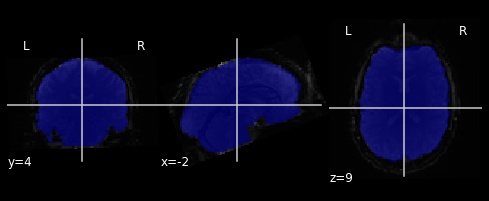

In [35]:
from nilearn.masking import compute_epi_mask
mask = nilearn.masking.compute_epi_mask(data)

plotting.view_img(image.mean_img(data))
# display.add_edges(mask)

plotting.plot_roi(mask, image.mean_img(data))

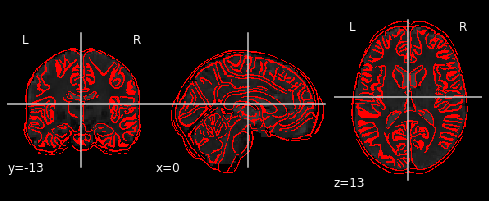

In [6]:
display = plotting.plot_anat(image.mean_img("/home/ltetrel/Documents/data/neuromod/to_generate/ses-vid001_task-video_run-01_bold.nii.gz"))
display.add_edges("/home/ltetrel/Documents/work/DeepNeuroAN/template/MNI152_T1_1mm_brain.nii.gz")

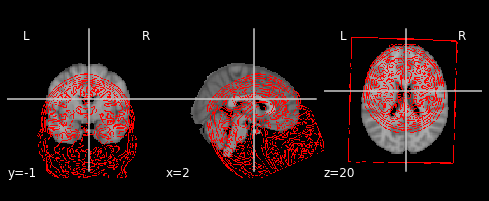

In [4]:
display = plotting.plot_anat("/home/ltetrel/Documents/work/DeepNeuroAN/data/MNI152_T1_1mm_brain")
display.add_edges("/home/ltetrel/Documents/data/%s_to_grid.nii.gz" %t_name[:6])

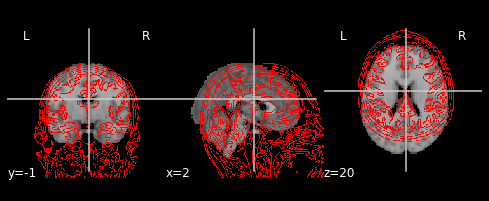

In [5]:
display = plotting.plot_anat("/home/ltetrel/Documents/work/DeepNeuroAN/data/MNI152_T1_1mm_brain")
display.add_edges("/home/ltetrel/Documents/data/%s_source.nii.gz" %t_name[:6])

In [6]:
affine.GetParameters()

(1.06345736980438,
 -0.0606516972184181,
 -0.0281794872134924,
 0.0391766466200352,
 1.1099591255188,
 -0.454279899597168,
 0.0446942299604416,
 0.470217764377594,
 1.06870269775391,
 -1.955242395401,
 -11.7487096786499,
 9.42623424530029)

In [7]:
affine.GetMatrix()

(1.06345736980438,
 -0.0606516972184181,
 -0.0281794872134924,
 0.0391766466200352,
 1.1099591255188,
 -0.454279899597168,
 0.0446942299604416,
 0.470217764377594,
 1.06870269775391)

In [8]:
affine.GetTranslation()

(-1.955242395401, -11.7487096786499, 9.42623424530029)